In [1]:
# %%capture cap
!pip install -qq ipywidgets
!pip install -qq autogluon scikit-learn==1.5.2 
!apt-get install -qq -y graphviz graphviz-dev && pip install -q pydot
!pip install -qq pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 10.3 MB/s eta 0:0

In [2]:
import torch
import os
import pydot

import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import time, sleep
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 500)
plt.style.use("ggplot")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

print("Packages import succesful!")

Packages import succesful!


In [3]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e12/"
submit = pd.read_csv(PATH+"sample_submission.csv")

list_of_targets = [
    'age',
    'bmi',
    'physical_activity_minutes_per_week',
    'family_history_diabetes',
    'systolic_bp',
]

TARGET = list_of_targets[4]

train = pd.read_csv(PATH+"train.csv").drop(['id', 'diagnosed_diabetes', TARGET], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id', TARGET], axis=1)

NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

ORIG_PATH = '/kaggle/input/diabetes-health-indicators-dataset/'
orig = pd.read_csv(ORIG_PATH+'diabetes_dataset.csv')[BASE+[TARGET]]

for (name, df) in dict(Train=train, Test=test, Orignal=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (700000, 23)
Test shape: (300000, 23)
Orignal shape: (100000, 24)

Total Numerical: 17
Total Categorical: 6
Total base features: 23


In [4]:
orig.head()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,gender,ethnicity,education_level,income_level,smoking_status,employment_status,systolic_bp
0,58,0,215,5.7,7.9,7.9,30.5,0.89,78,68,239,41,160,145,0,0,0,Male,Asian,Highschool,Lower-Middle,Never,Employed,134
1,48,1,143,6.7,6.5,8.7,23.1,0.80,76,67,116,55,50,30,0,0,0,Female,White,Highschool,Middle,Former,Employed,129
2,60,1,57,6.4,10.0,8.1,22.2,0.81,73,74,213,66,99,36,1,0,0,Male,Hispanic,Highschool,Middle,Never,Unemployed,115
3,74,0,49,3.4,6.6,5.2,26.8,0.88,93,68,171,50,79,140,0,0,0,Female,Black,Highschool,Low,Never,Retired,120
4,46,1,109,7.2,7.4,5.0,21.2,0.78,67,67,210,52,125,160,0,0,0,Male,White,Graduate,Middle,Never,Retired,92


In [5]:
MODELS_PATH = "/kaggle/working/AG_DIABETES_models/"
# !rm -r {MODELS_PATH}

In [6]:
from autogluon.tabular import TabularPredictor

In [7]:
predictor = TabularPredictor(
                label = TARGET,
         # problem_type = "regression",
          # eval_metric = "roc_auc",
                 path = MODELS_PATH,
    ).fit(
                   train_data = orig,
                      presets = "best",
                num_bag_folds = 8,
             # dynamic_stacking = False,
             # num_stack_levels = 1,
                   time_limit = 3600*6,
                   # auto_stack = False,
                 # num_bag_sets = 2,
                  # ag_args_fit = {'num_cpus': os.cpu_count()},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Memory Avail:       29.78 GB / 31.35 GB (95.0%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon w

In [8]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}") 

## -- Observe RUN 1 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 19
-> Best model   : WeightedEnsemble_L2


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.060557,accuracy,421.803424,8493.343176,0.040020,30.309005,3,True,19
1,WeightedEnsemble_L2,0.060557,accuracy,421.832388,8488.133663,0.068985,25.099492,2,True,15
2,NeuralNetTorch_BAG_L1,0.060257,accuracy,0.841791,386.000777,0.841791,386.000777,1,True,10
3,NeuralNetTorch_r79_BAG_L1,0.059676,accuracy,1.553440,485.893939,1.553440,485.893939,1,True,13
4,CatBoost_r177_BAG_L1,0.059246,accuracy,0.366043,392.336723,0.366043,392.336723,1,True,12
5,NeuralNetFastAI_BAG_L1,0.058716,accuracy,2.563593,370.143965,2.563593,370.143965,1,True,1
6,LightGBM_r131_BAG_L1,0.058166,accuracy,419.788036,500.477884,419.788036,500.477884,1,True,14
7,LightGBMXT_BAG_L1,0.058106,accuracy,59.760646,248.673313,59.760646,248.673313,1,True,2
8,NeuralNetFastAI_BAG_L2,0.057635,accuracy,775.786571,11226.310586,6.982938,843.747906,2,True,16
9,CatBoost_BAG_L1,0.057525,accuracy,0.767533,7184.218787,0.767533,7184.218787,1,True,6


In [9]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [10]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [11]:
## -- Create folder directory to save predictions --
SAVE_PATH = '/kaggle/working/AG_DIABETES_preds/'
!mkdir {SAVE_PATH}

In [12]:
%%time
## -- Predictions for MULTICLASS FEATURE --
TRAIN_preds = predictor.predict(train, as_pandas=False)
np.save(f"{SAVE_PATH}train_AG_on_{TARGET}.npy", TRAIN_preds)
print(f" - {len(TRAIN_preds)} Train predictions saved!")

TEST_preds = predictor.predict(test, as_pandas=False)
np.save(f"{SAVE_PATH}test_AG_on_{TARGET}.npy", TEST_preds)
print(f" - {len(TEST_preds)} Test predictions saved!")

np.vstack((TRAIN_preds[:10], TEST_preds[:10]))

 - 700000 Train predictions saved!
 - 300000 Test predictions saved!
CPU times: user 7h 59min 36s, sys: 45 s, total: 8h 21s
Wall time: 4h 44s


array([[ 90, 112,  90, 120, 120,  90,  90, 120,  90, 116],
       [112,  90, 116, 120, 124,  90, 124,  90, 120, 112]])

In [13]:
# %%time
# ## -- Predictions for BINARY FEATURE --
# TRAIN_preds = predictor.predict_proba(train, as_multiclass=False, as_pandas=False)
# np.save(f"{SAVE_PATH}train_AG_on_{TARGET}.npy", TRAIN_preds)
# print(f" - {len(TRAIN_preds)} Train predictions saved!")

# TEST_preds = predictor.predict_proba(test, as_multiclass=False, as_pandas=False)
# np.save(f"{SAVE_PATH}test_AG_on_{TARGET}.npy", TEST_preds)
# print(f" - {len(TEST_preds)} Test predictions saved!")

# np.vstack((TRAIN_preds[:10], TEST_preds[:10]))

In [14]:
# ## -- Predictions for REGRESSION FEATURE --
# TRAIN_ = predictor.predict(train)
# np.save(f"{SAVE_PATH}oof_AG_on_{TARGET}.npy", TRAIN_)
# print(" - Train predictions saved!")

# TEST_ = predictor.predict(test)
# np.save(f"{SAVE_PATH}pred_AG_on_{TARGET}.npy", TEST_)
# print(" - Test predictions saved!")

# TRAIN_[:5], TEST_[:5]

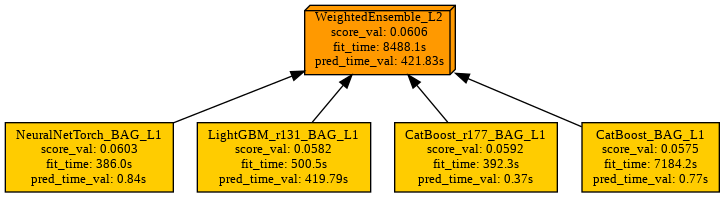

In [15]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image(f'{MODELS_PATH}ensemble_model.png'))

In [16]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
# !zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

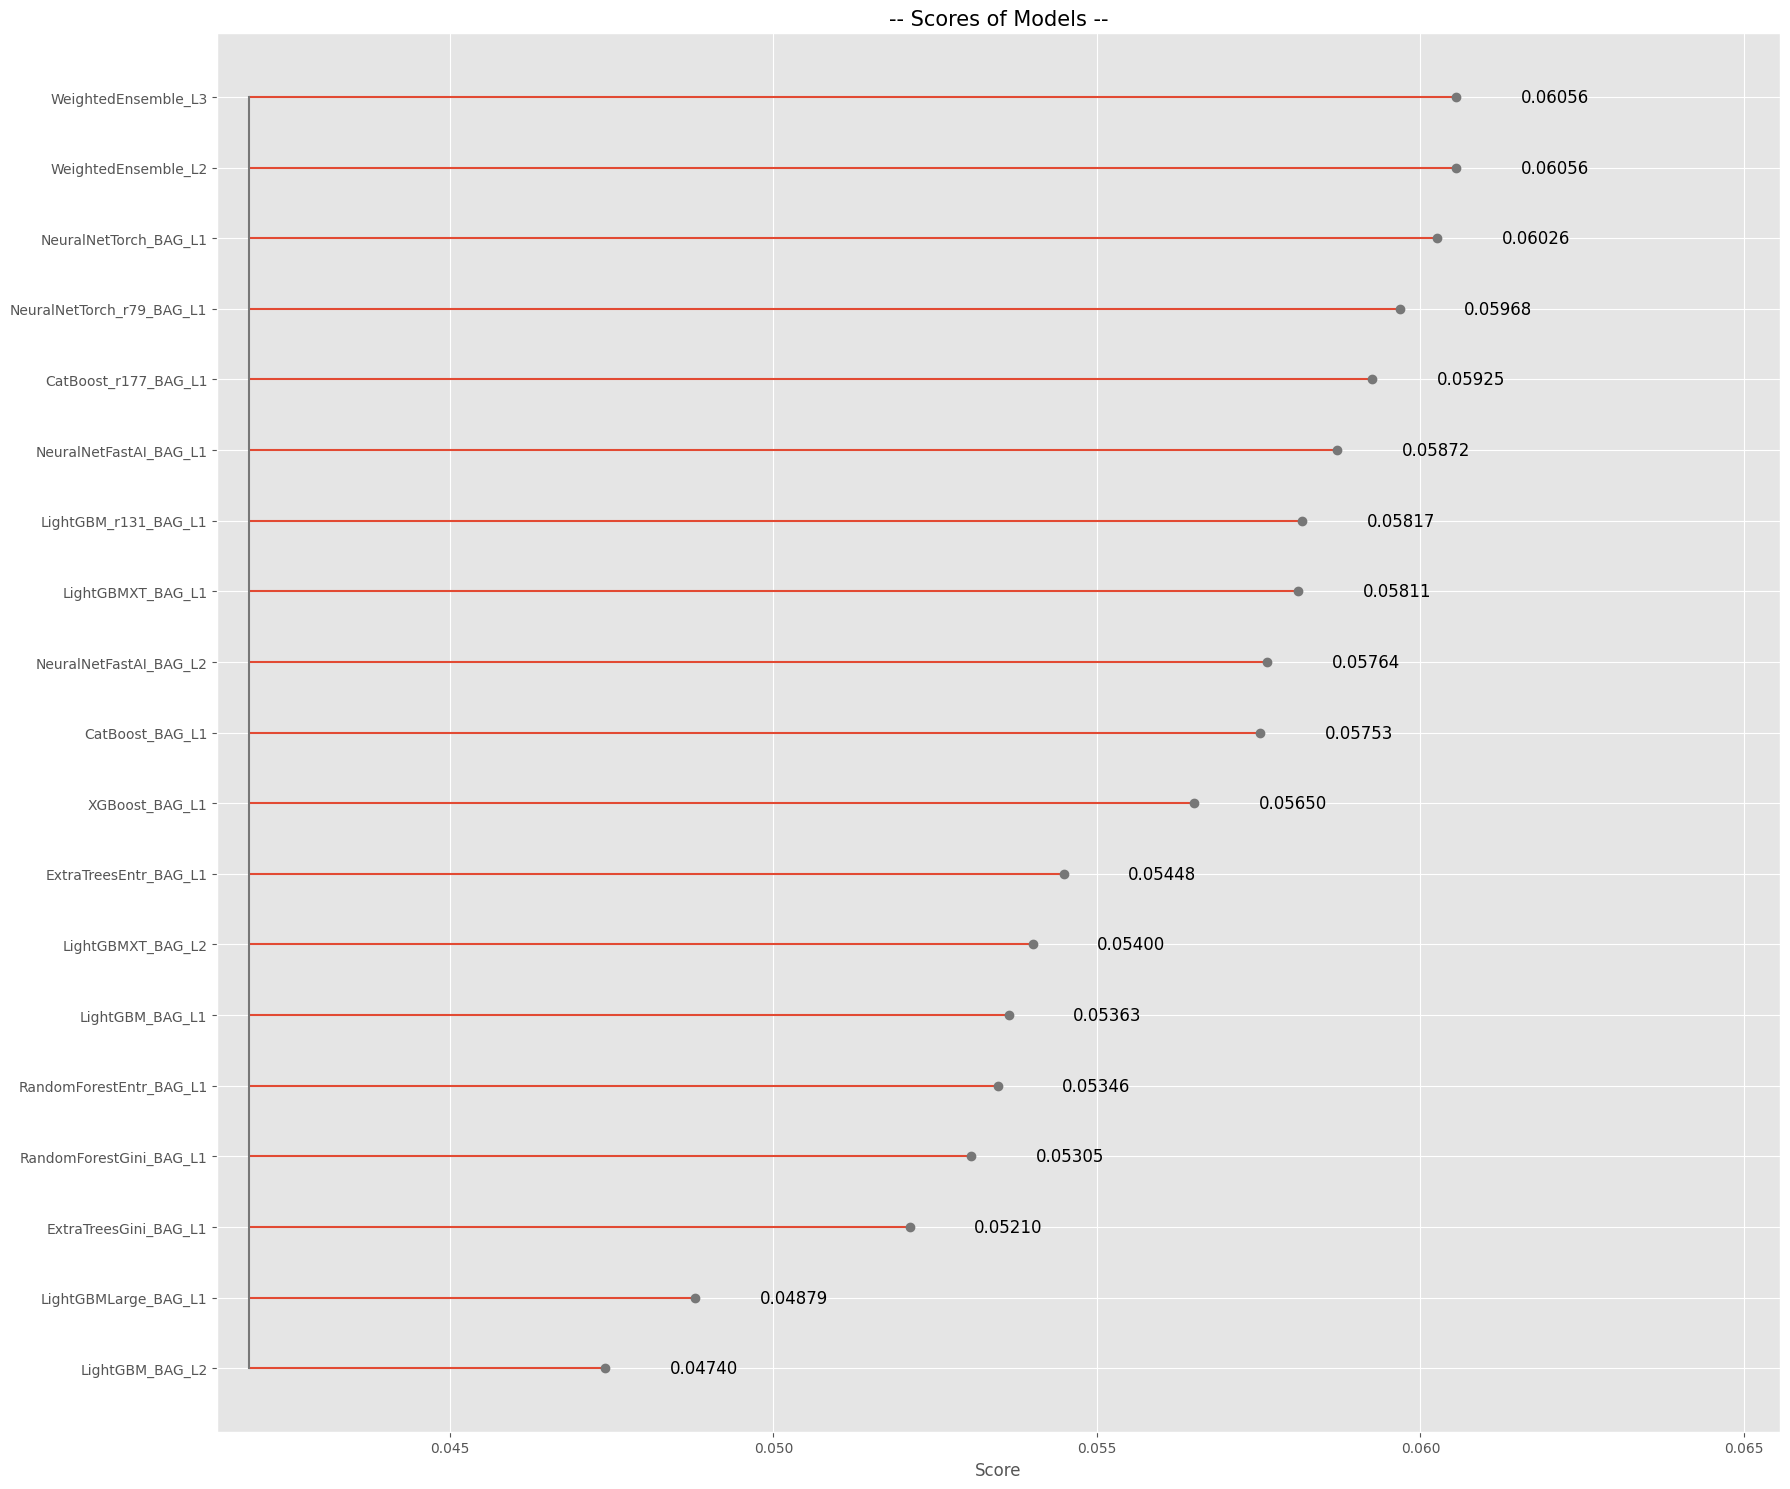

In [17]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.005)
plt.xlabel('Score')
plt.title('-- Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [18]:
# predictor.model_names()

In [19]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

In [20]:
# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [21]:
## -- OPTIONAL: Remove stored files --
!rm -r {MODELS_PATH}

In [22]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

